In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import vectorbt as vbt
import yfinance as yf
from tqdm import tqdm
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import RadiusNeighborsRegressor

import cufflinks as cf
cf.go_offline()

import warnings
warnings.simplefilter(action='ignore')

In [93]:
data = pd.read_csv('NQ.csv')
factors = pd.read_csv('factor.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
nq_price = pd.read_csv('NQC1.csv')
nq_price['Date'] = pd.to_datetime(nq_price['Date'])
nq_price = nq_price.set_index('Date')

In [94]:
# 用前一期填上空值
df_fill = data.dropna()
# df_fill = data.fillna(method='ffill')

df_features = df_fill.iloc[:,1:]
df_features = df_features.pct_change().dropna()
df_features.replace([np.inf,-np.inf],np.nan,inplace=True)
df_features = df_features.fillna(method='ffill')

df_clean = df_features.copy()
df_clean['y'] = df_fill['y']

In [95]:
lead_factor = factors['lead_factor'].dropna().to_list()
lead_factor_days = factors['lead_factors_days'].dropna().to_list()
lead_factor_dir = factors['lead_factor_dir'].dropna().to_list()
lead_factor_dir_days = factors['lead_factor_dir_days'].dropna().to_list()
k_means_pick = factors['k_means'].dropna().to_list()
k_means_dir = factors['k_means_dir'].dropna().to_list()
k_means_y = factors['k_means_y'].dropna().to_list()
k_means_y.remove('y')
k_means_y_dir = factors['k_means_y_dir'].dropna().to_list()
k_means_y_dir.remove('y')
low_corr = factors['low_corr'].dropna().to_list()
low_corr_dir = factors['low_corr_dir'].dropna().to_list()
similar_dir = factors['similar_dir'].dropna().to_list()

In [96]:
select = lead_factor_dir
print(select)
print(len(select))

['g8', 'h10', 'i11', 'h7', 'c8', 'b3', 'i10', 'c10', 'i2', 'n4']
10


In [97]:
## value
df = (df_clean - df_clean.mean())/df_clean.std()
# df = (data - data.mean())/data.std()
ratio = 0.7
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df[item] = df[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df[item] = df[item].shift(int(days))
df = df.dropna()
df_train = df.iloc[:int(len(df)*ratio)]
df_test = df.iloc[int(len(df)*ratio):]
x_train = df_train[select]
x_test = df_test[select]

y_train = df_train['y']
y_test = df_test['y']

In [98]:
df_result = pd.DataFrame()
train_unit = 122
test_unit = 1
start = 0
for i in tqdm(range((train_unit),len(df))):
    # print(start,i)
    duration = df.iloc[start:i]
    x_train = duration.iloc[:-test_unit][select]
    y_train = duration.iloc[:-test_unit]['y']
    x_test = duration.iloc[-test_unit:][select]
    start += 1
    # print(duration.iloc[0].name,duration.iloc[-1].name,len(duration),duration.iloc[-test_unit-1].name)
    model1 = HistGradientBoostingRegressor(max_depth = 1, learning_rate=2).fit(x_train,y_train)
    predicted1 = model1.predict(x_test)
    model2 = HistGradientBoostingRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
    predicted2 = model2.predict(x_test)
    model3 = HistGradientBoostingRegressor(max_depth = 7, learning_rate=2).fit(x_train,y_train)
    predicted3 = model3.predict(x_test)
    model4 = XGBRegressor(max_depth = 13, learning_rate=2).fit(x_train,y_train)
    predicted4 = model4.predict(x_test)
    model5 = XGBRegressor(max_depth = 2, learning_rate=2).fit(x_train,y_train)
    predicted5 = model5.predict(x_test)
    model6 = RadiusNeighborsRegressor(radius=1.7).fit(x_train,y_train)
    predicted6 = model6.predict(x_test)
    model7 = RadiusNeighborsRegressor(radius=1.4).fit(x_train,y_train)
    predicted7 = model7.predict(x_test)
    predicted6 = np.nan_to_num(predicted6,nan=np.mean(y_train[-5:]))
    predicted7 = np.nan_to_num(predicted7,nan=np.mean(y_train[-5:]))
    predicted = (predicted1+predicted2+predicted3+predicted4+predicted5+predicted6+predicted7)/7
    # predicted =predicted6
    for d in range(test_unit):
        day = duration.iloc[-test_unit:].index[d]
        predict = predicted[d]
        df_result.loc[day,'y'] = data.loc[day,'y']
        df_result.loc[day,'predict'] = predict 

df_result['y'] = data['y']
df_result = pd.concat([df_result,nq_price[['Open','Close']]],axis=1).dropna()
print(df_result)



100%|██████████| 749/749 [01:50<00:00,  6.78it/s]

                   y   predict      Open     Close
2021-06-11  0.001575  0.135068  13971.00  13995.25
2021-06-14  0.007298  0.114277  14010.75  14123.25
2021-06-15 -0.005899  0.118315  14113.75  14027.00
2021-06-16 -0.005554  0.693347  14044.25  13975.75
2021-06-17  0.018347  0.248257  13912.50  14155.75
...              ...       ...       ...       ...
2024-07-24 -0.021571 -0.008680  19633.50  19205.00
2024-07-25 -0.012479 -0.201696  19232.25  18992.25
2024-07-26 -0.000209 -0.132921  19179.25  19175.25
2024-07-29 -0.005282 -0.050436  19309.75  19207.75
2024-07-30 -0.016868 -0.000690  19267.50  18942.50

[742 rows x 4 columns]


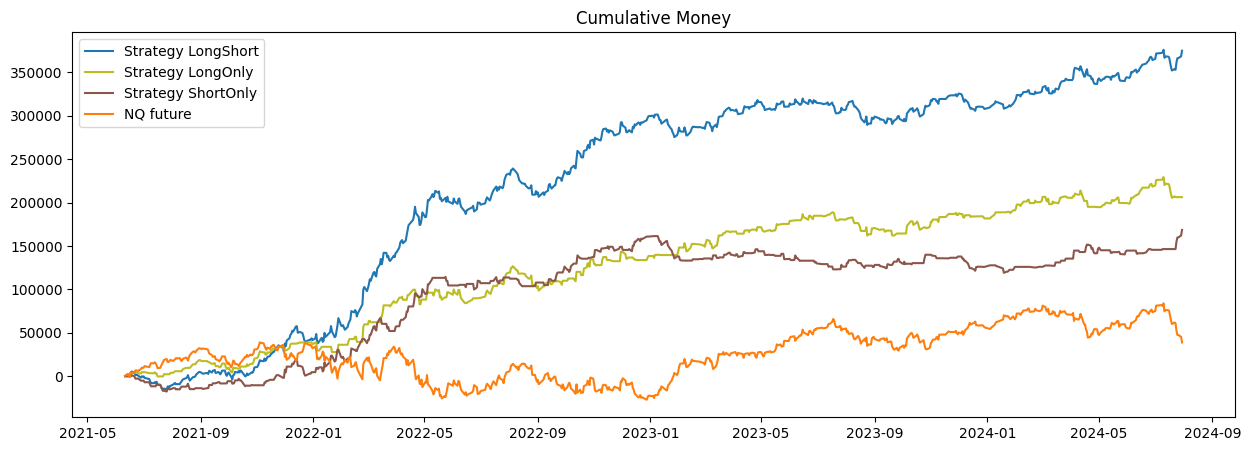

In [112]:
df_result['in_price'] = (df_result['Open']+0.5)*20
df_result['out_price'] = (df_result['Close']-0.5)*20
df_result['price_gap'] = (df_result['out_price']-df_result['in_price'])
df_result['price_gap_LongShort'] = np.where(df_result['predict']>0,df_result['price_gap']-20,-df_result['price_gap']-20)
df_result['price_gap_LongOnly'] = np.where(df_result['predict']>0,df_result['price_gap']-20,0)
df_result['price_gap_ShortOnly'] = np.where(df_result['predict']<0,-df_result['price_gap']-20,0)
df_result['Cum_price_LongShort'] = df_result['price_gap_LongShort'].cumsum()
df_result['Cum_price_LongOnly'] = df_result['price_gap_LongOnly'].cumsum()
df_result['Cum_price_ShortOnly'] = df_result['price_gap_ShortOnly'].cumsum()
df_result['y_gap'] = df_result['Close']*20 - df_result['Open']*20
# df_result['y_gap'] = np.where(df_result['y']>0,df_result['y_gap']-20,-df_result['y_gap']-20)
df_result['Cum_y'] = (df_result['y_gap']-20).cumsum()
# df_result
plt.figure(figsize=(15,5))
plt.title('Cumulative Money')
plt.plot(df_result['Cum_price_LongShort'],color='C10',label='Strategy LongShort')
plt.plot(df_result['Cum_price_LongOnly'],color='C08',label='Strategy LongOnly')
plt.plot(df_result['Cum_price_ShortOnly'],color='C05',label='Strategy ShortOnly')
plt.plot(df_result['Cum_y'],color='C01',label='NQ future')
plt.legend()
plt.show()

### **策略(一)**
- 預測為正: 做多
- 預測為負: 做空

In [99]:
df_result['signal'] = np.where(df_result['predict']<0,-1,1)
# strategy return
df_result['return_longshort'] = np.where(df_result['signal']==1,df_result['y'],-df_result['y'])
df_result['return_longonly'] = np.where(df_result['signal']==1,df_result['y'],0)
df_result['return_shortonly'] = np.where(df_result['signal']==-1,-df_result['y'],0)
df_result['Cum_ret_longshort'] = (df_result['return_longshort']+1).cumprod()-1
df_result['Cum_ret_longonly'] = (df_result['return_longonly']+1).cumprod()-1
df_result['Cum_ret_shortonly'] = (df_result['return_shortonly']+1).cumprod()-1
df_result['Cum_ret_y'] = (df_result['y']+1).cumprod()-1
positive_LongShort = len(df_result[df_result['Cum_ret_longshort']>0])
positive_LongOnly = len(df_result[df_result['Cum_ret_longonly']>0])
positive_ShortOnly = len(df_result[df_result['Cum_ret_shortonly']>0])
positive_y = len(df_result[df_result['Cum_ret_y']>0])
print(f'LongShort Strategy absolute positive : {positive_LongShort}')
print(f'LongOnly Strategy absolute positive : {positive_LongOnly}')
print(f'ShortOnly Strategy absolute positive : {positive_ShortOnly}')
print(f'NQ Future absolute positive : {positive_y}')

LongShort Strategy absolute positive : 712
LongOnly Strategy absolute positive : 741
ShortOnly Strategy absolute positive : 635
NQ Future absolute positive : 545


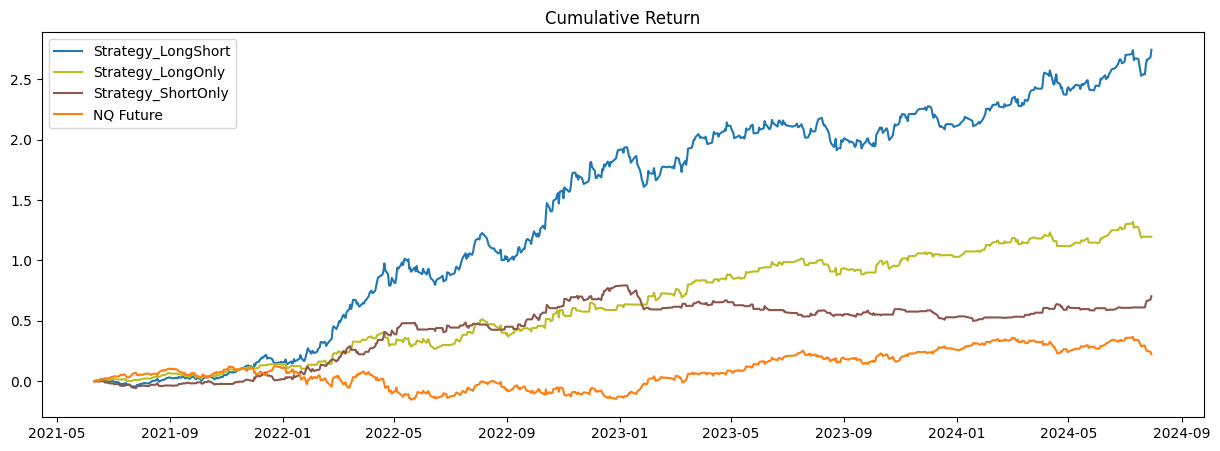

In [100]:
plt.figure(figsize=(15,5))
plt.title('Cumulative Return')
plt.plot(df_result['Cum_ret_longshort'],color='C10',label='Strategy_LongShort')
plt.plot(df_result['Cum_ret_longonly'],color='C08',label='Strategy_LongOnly')
plt.plot(df_result['Cum_ret_shortonly'],color='C05',label='Strategy_ShortOnly')
plt.plot(df_result['Cum_ret_y'],color='C01',label='NQ Future')
plt.legend()
plt.show()

In [101]:

df_ret = pd.concat({
    'long_only':df_result['return_longonly'],
    'short_only':df_result['return_shortonly'],
    'long_short':df_result['return_longshort'],
    'NQ_future':df_result['y']
},axis=1)

fig = ((df_ret+1).cumprod()-1).iplot(layout=dict(width=1000,height=500,title='Cumulative Return Comparison'),asFigure=True)
# fig.add_vline(x='2024-08-01',line=dict(color='red',width=2,dash='dash'))
fig.show()